In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as col
import matplotlib.image as mpimg
from scipy import signal
from scipy import ndimage

def rgb2gray(rgb_image):
    return np.dot(rgb_image[...,:3], [0.299, 0.587, 0.114])

def multi_view( images ):
    images_count = len( images )
    fig = plt.figure(figsize=(10,20))
    for row in range( images_count  ):
        ax1 = fig.add_subplot( images_count , 1 , row + 1)    
        ax1.imshow( images[ row ], cmap='gray' )

def view( image ):
    plt.figure(figsize=(10,20))
    plt.imshow( image )

def box_filter( w ):
    return np.ones((w,w)) / (w*w)

def gaussian_kernel( kernlen , std ):
    """Returns a 2D Gaussian kernel array."""
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d

## Load and Preprocess Images $I$


In [3]:
images_files = ["chess.png",
               "francesco-bagnato-insect-macro.jpg", "entrance-of-university.jpg", 
               "francesco-bagnato-insect.jpg" ]

images = [ mpimg.imread( file ) for file in images_files ]

images_gr = [ rgb2gray( image ) if len(image.shape) > 2 else image for image in images ]

images_smooth = [ signal.convolve2d(img, gaussian_kernel(7,1.0) ,'same') for img in images_gr ]



## Define Gradient Function for $I_x$ and $I_y$

[None, None, None, None]

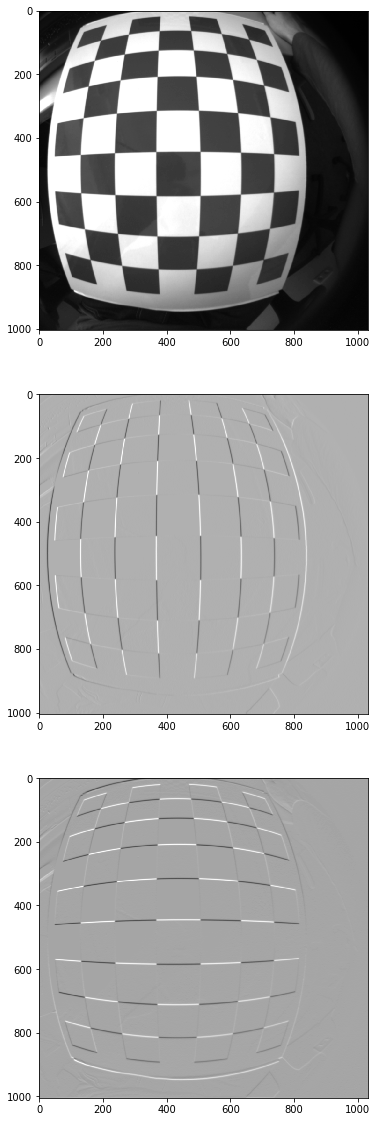

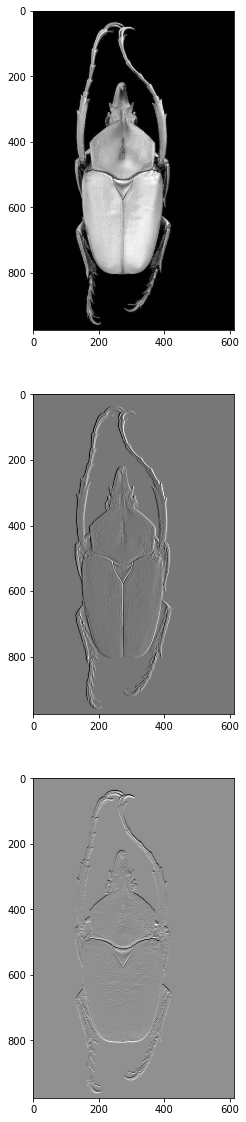

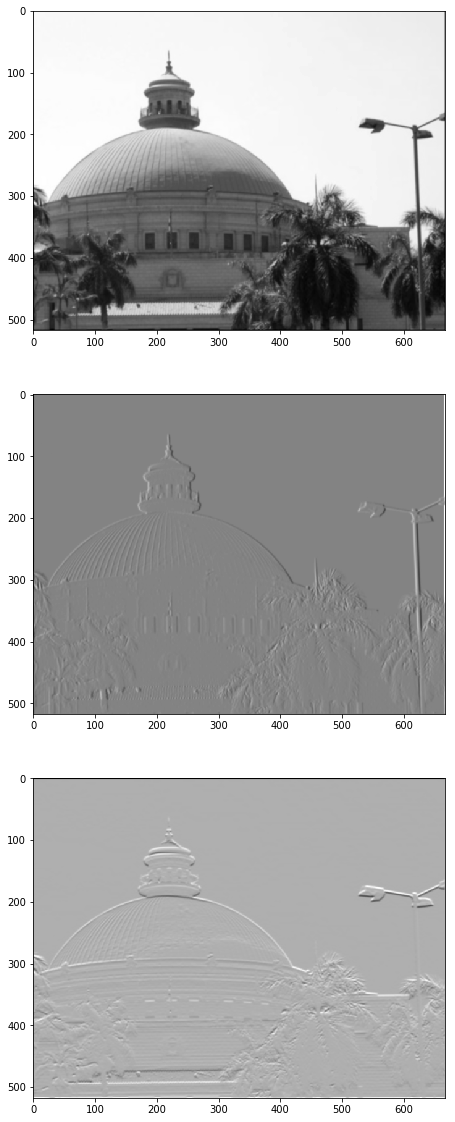

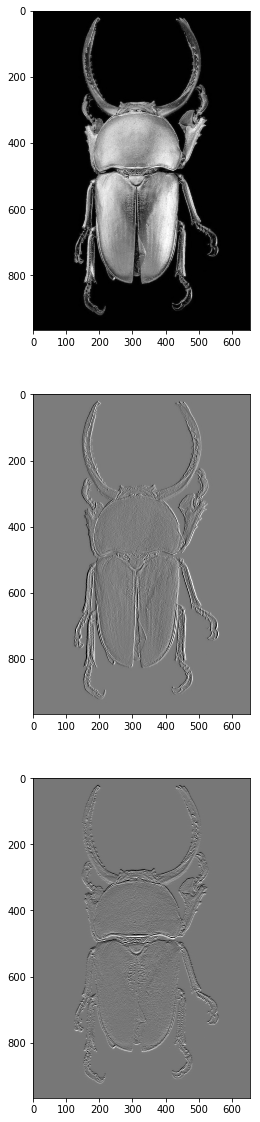

In [4]:
sobel_h = np.array([[ -1 , 0 , 1 ] ,
                    [ -2 , 0 , 2 ] ,
                    [ -1 , 0 , 1 ]])
sobel_v = sobel_h.transpose()

images_Ix = [ signal.convolve2d( img , sobel_h ,'same') for img in images_smooth ]
images_Iy = [ signal.convolve2d( img , sobel_v ,'same') for img in images_smooth ]

[ multi_view( comb ) for comb in list(zip( images_smooth,images_Ix, images_Iy ))]

## Define $I_{xx}$, $I_{yy}$, and $I_{xy}$

In [5]:
images_Ixx = [ np.multiply( img, img) for img in images_Ix ]
images_Iyy = [ np.multiply( img, img) for img in images_Iy ]
images_Ixy = [ np.multiply( imgx, imgy) for imgx, imgy in zip( images_Ix, images_Iy )]



## Compute the $\sum I_{xx}$, $\sum I_{yy}$, and $\sum I_{xy}$ over a window $w$

We can compute $M$ as following:

$ M = 
\begin{bmatrix}
I_{xx}       & I_{xy} \\
I_{xy}       & I_{yy}
\end{bmatrix}
$

But if we need more robust detection, we can compute $M$ over a window, so we are now able to detect larger corner that lives inside a window of pixels, instead of a single pixel.

To detect a corner in a region within a window, we can compute $M$ as following: 

$
M(p) = \sum_{i,j} w(i,j)
\begin{bmatrix}
I_{xx}(i,j)       & I_{xy}(i,j) \\
I_{xy}(i,j)       & I_{yy}(i,j)
\end{bmatrix}
$

$
M(p) =
\begin{bmatrix}
\sum_{i,j} w(i,j) I_{xx}(i,j)       & \sum_{i,j} w(i,j) I_{xy}(i,j) \\
\sum_{i,j} w(i,j) I_{xy}(i,j)       & \sum_{i,j} w(i,j) I_{yy}(i,j)
\end{bmatrix} 
$

$
M(p) =
\begin{bmatrix}
\hat{I}_{xx}       & \hat{I}_{xy} \\
\hat{I}_{xy}       & \hat{I}_{yy}
\end{bmatrix}
$


Now let's assume a uniform window of size $5 \times 5$, in which we can apply a box filter over each of $I_{xx}$, $I_{yy}$, and $I_{xy}$.

In [12]:
images_Ixx_hat = [ signal.convolve2d( img ,  gaussian_kernel(21,1.0) ,'same') for img in images_Ixx ]
images_Iyy_hat = [ signal.convolve2d( img ,  gaussian_kernel(21,1.0) , 'same') for img in images_Iyy ]
images_Ixy_hat = [ signal.convolve2d( img ,  gaussian_kernel(21,1.0)  ,'same') for img in images_Ixy ]

## Evaluating corners using $R = (\lambda_1 \times \lambda_2) - k (\lambda_1 + \lambda_2)$

Let $\lambda_1$ and $\lambda_2$ be the eigen values of the matrix $M$. We can say that $M$ corresponds to a strong corner when having both eigen values $\lambda_1$ and $\lambda_2$ with relative highe values. Another case when having either $\lambda_1$ or $\lambda_2$ relatively larger than the other, then we infer that $M$ corresponds to an edge; the reason we call *Harris operator* corner and edge detector. Otherwise, if both $\lambda_1$ and $\lambda_2$ having low values then $M$ corresponds to neither a corner nor an edge.

![](https://sbme-tutorials.github.io/2019/cv/images/eig2.png)

More over, instead of computing the eigen values we can estimate the quantities $(\lambda_1 \times \lambda_2)$ and $(\lambda_1 + \lambda_2)$ without the need to compute each of $\lambda_1$ and $\lambda_2$. We can rather compute these quantities as following:

$det(M) = \lambda_1 \times \lambda_2$

$trace(M) = \lambda_1 + \lambda_2 $

$ \therefore R = det(M) - k * \text{trace}(M)$

$k$ is empirical constant, recommended $k = 0.04-0.06$

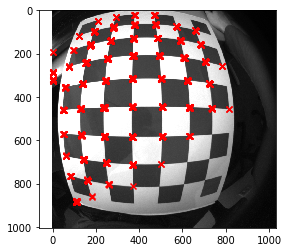

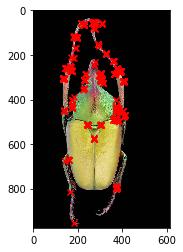

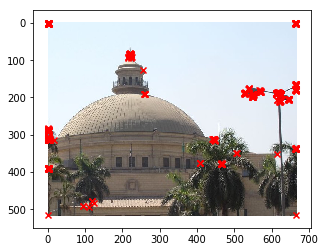

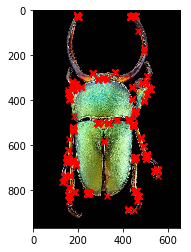

In [13]:
K = 0.05

images_detM = [ np.multiply(img_xx,img_yy) - np.multiply(img_xy,img_xy) \
               for img_xx,img_yy,img_xy in zip(images_Ixx_hat, images_Iyy_hat, images_Ixy_hat)]
images_trM = [ img_xx + img_yy for img_xx, img_yy  in zip(images_Ixx_hat, images_Iyy_hat) ]
images_R = [ detM - K * trM for detM, trM in zip( images_detM, images_trM )]


ratio = 0.2 # Tunable value. to keep adaptivity per image.
images_corners = [  np.abs(R) >  np.quantile( np.abs(R),0.999)  for R in images_R ]

from PIL import Image,ImageDraw

for corners,image in zip(images_corners,images) : 
    plt.imshow(image,zorder=1)
    
    corners_pos = np.argwhere(corners)
    
    plt.scatter(corners_pos[:,1],corners_pos[:,0],zorder=2, c = 'r',marker ='x')

    plt.show()
    
